### Getting Data from PostgreSQL DB

Prior to this we have successfull obtained our dataset from Kaggle and migrated it from a `sqlite` database to a `PostgreSQL` database. Now we can query from it using the `psycopg2` package.

#### Required Packages

In [1]:
import pandas as pd       # Data manipulation
import psycopg2           # Query against psql dbs
import numpy as np        # math and arrays
import matplotlib.pyplot as plt# plotting
from scipy import stats
import scipy
import seaborn as sns

#### Create Connection

We stored out data in a `PostgreSQL` database named `soccer`.

In [2]:
conn = psycopg2.connect("dbname=soccer")

---

---

### Set up queries

We will write queries for each of our proposed hypothesis tests.

#### 2) Impact of defence aggression on average allowed goals. 

In [3]:
query_2 = """
    /* Home Teams */
    select 
        country_name, league_name, team_short_name 
        ,team_long_name, season, stage, match_date
        ,goals_allowed
        ,team_def_aggr_rating
        ,team_def_aggr_scale
        ,'H' as home_or_away
    from
    (
    select
        c.name as country_name
        ,l.name as league_name
        ,ht.team_short_name 
        ,ht.team_long_name 
        ,m.season, m.stage, m.date as match_date, m.match_api_id
        ,m.away_team_goal as goals_allowed
        ,hta.defenceaggression as team_def_aggr_rating
        ,hta.defenceaggressionclass as team_def_aggr_scale
        ,row_number() over (partition by m.home_team_api_id, m.date
            order by to_date(hta.date, 'yyyy-mm-dd')) as enumer
    from
        match m
        inner join country c on m.country_id = c.id
        inner join league l on m.league_id = l.id
        inner join team ht on m.home_team_api_id = ht.team_api_id
        inner join team_attributes hta on hta.team_api_id = m.home_team_api_id
            and to_date(m.date, 'yyyy-mm-dd') 
                <= to_date(hta.date, 'yyyy-mm-dd') 
    ) ranked
    where 
        enumer = 1
        
    union all
    
    /* Away teams */
    select 
        country_name, league_name, team_short_name 
        ,team_long_name, season, stage, match_date
        ,goals_allowed
        ,team_def_aggr_rating
        ,team_def_aggr_scale
        ,'A' as home_or_away
    from
    (
    select
        c.name as country_name
        ,l.name as league_name
        ,at.team_short_name 
        ,at.team_long_name 
        ,m.season, m.stage, m.date as match_date, m.match_api_id
        ,m.home_team_goal as goals_allowed
        ,ata.defenceaggression as team_def_aggr_rating
        ,ata.defenceaggressionclass as team_def_aggr_scale
        ,row_number() over (partition by m.home_team_api_id, m.date
            order by to_date(ata.date, 'yyyy-mm-dd')) as enumer
    from
        match m
        inner join country c on m.country_id = c.id
        inner join league l on m.league_id = l.id
        inner join team at on m.away_team_api_id = at.team_api_id
        inner join team_attributes ata on ata.team_api_id = m.home_team_api_id
            and to_date(m.date, 'yyyy-mm-dd') 
                <= to_date(ata.date, 'yyyy-mm-dd') 
    ) ranked
    where 
        enumer = 1
;
"""

### Run queries, put contents into pandas DataFrame

In [4]:
cur = conn.cursor()
cur.execute(query_2)

In [5]:
soccer = pd.DataFrame(cur.fetchall())
soccer.columns = [desc[0] for desc in cur.description]

In [6]:
soccer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45494 entries, 0 to 45493
Data columns (total 11 columns):
country_name            45494 non-null object
league_name             45494 non-null object
team_short_name         45494 non-null object
team_long_name          45494 non-null object
season                  45494 non-null object
stage                   45494 non-null int64
match_date              45494 non-null object
goals_allowed           45494 non-null int64
team_def_aggr_rating    45494 non-null int64
team_def_aggr_scale     45494 non-null object
home_or_away            45494 non-null object
dtypes: int64(3), object(8)
memory usage: 3.8+ MB


In [7]:
soccer.head(10).T

,0,1,2,3,4,5,6,7,8,9
country_name,Poland,Poland,Poland,Poland,Poland,Poland,Poland,Poland,Poland,Poland
league_name,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa,Poland Ekstraklasa
team_short_name,CHO,CHO,CHO,CHO,CHO,CHO,CHO,CHO,CHO,CHO
team_long_name,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów,Ruch Chorzów
season,2008/2009,2008/2009,2008/2009,2008/2009,2008/2009,2008/2009,2008/2009,2008/2009,2008/2009,2008/2009
stage,2,3,5,7,9,12,13,15,16,18
match_date,2008-08-16 00:00:00,2008-08-22 00:00:00,2008-09-12 00:00:00,2008-09-27 00:00:00,2008-10-19 00:00:00,2008-11-08 00:00:00,2008-11-11 00:00:00,2008-11-21 00:00:00,2008-11-29 00:00:00,2009-02-28 00:00:00
goals_allowed,1,1,0,0,0,0,2,1,0,1
team_def_aggr_rating,60,60,60,60,60,60,60,60,60,60
team_def_aggr_scale,Press,Press,Press,Press,Press,Press,Press,Press,Press,Press


In [8]:
soccer['team_def_aggr_rating'].describe()

count    45494.000000
mean        49.729195
std         10.670449
min         24.000000
25%         43.000000
50%         48.000000
75%         57.000000
max         72.000000
Name: team_def_aggr_rating, dtype: float64

In [9]:
#teams_65 = soccer.loc[soccer['team_def_aggr_rating']>=65, ['team_long_name', 'goals_allowed']]
#teams_65

In [10]:
soccer_team_def_goals = soccer[['team_def_aggr_rating', 'goals_allowed']]

In [11]:
team_65 = soccer_team_def_goals[soccer.team_def_aggr_rating >= 65]
team_65.head()

,team_def_aggr_rating,goals_allowed
139,70,3
140,70,0
141,70,2
142,70,2
143,70,0


In [12]:
len(team_65)

5718

In [13]:
team_under_65 = soccer_team_def_goals[soccer.team_def_aggr_rating < 65]
team_under_65.head()

,team_def_aggr_rating,goals_allowed
0,60,1
1,60,1
2,60,0
3,60,0
4,60,0


**Impact of defence aggression on average allowed goals.   
Null :  There is no statistical difference in goals allowed with teams with defense aggression rating of greater than or equal to 65.  
Alternative: There is a statistical difference in goals allowed with teams with a defense aggression rating of greater than or equal to 65.   
Two-tail  
Alpha: 0.05**


In [14]:
sample_size = 100
trials = 1000

In [15]:
np.random.seed(1234)
sample = np.random.choice(team_65['goals_allowed'], size=sample_size, replace=False)

In [16]:
np.random.seed(1234)
sample_goals = []
for _ in range(trials):
    sample_goals.append(np.mean(np.random.choice(team_65['goals_allowed'], size=sample_size, replace=False)))

In [17]:
population_goals = soccer['goals_allowed']
print(len(sample_goals))
print(len(population_goals))

1000
45494


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


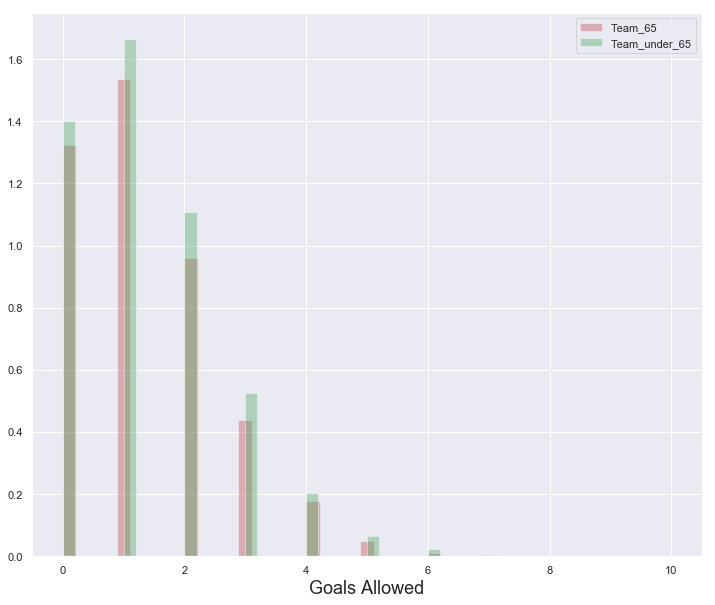

In [18]:
#team_65
#team_under_65
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(team_65['goals_allowed'], color='r', kde=False, norm_hist=True, label='Team_65') 
sns.distplot(team_under_65['goals_allowed'], color='g', kde=False, norm_hist=True, label='Team_under_65')
plt.xlabel('Goals Allowed', fontsize=18)
plt.legend()
plt.show()

In [76]:
#population_goals_mean = np.mean(population_goals)   
#sample_goals_mean = np.mean(sample_goals)
#alpha = 0.05 

In [77]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

In [78]:
t_stat, p_value = scipy.stats.ttest_ind(sample_goals, population_goals)
print('t-stat:', t_stat)
print('p-value:', p_value)

t-stat: -1.2924867765505719
p-value: 0.19619504592399523


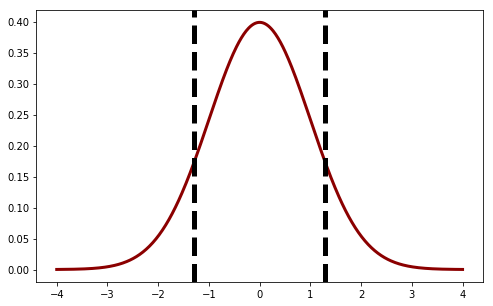

In [79]:
n_control = len(population_goals)
n_experimental = len(sample_goals)
visualize_t(t_stat, n_control, n_experimental)